*created 09 Jan 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 3. Classification tasks and random forests

So far we have dealt with ***regression***, where we assume the target is continuously varying. ***Classification*** would be the discrete version of that, i.e. predict the discrete labels given the data. Examples of this might be:

* Given attributes from the `penguins` data, predict the species.
* Classify whether an image is that of a cat or a dog.
* Predicting whether an Argo temperature/sainity profile is from a particular geographical location if I label it accordingly (e.g. from the Atlantic).

We are also going to introduce the use of ***decision trees*** and ensemble methods, of which the two algorithms of interest are ***random forests*** and ***gradient boosting***.

> ## Key Objective(s)
> 1. Demonstrate that classification is closerly related to finding separation between labelled data (and separation again depends on what you mean by distance).
> 2. Introduce other loss functions, some of which are closely related to ***activation functions*** that we will encounter when dealing with neural networks.
> 3. Go into a little detail about the anatomy of decision trees, and introduce ensemble based methods for decision trees.
> 4. Consider an example of decision tree as a classifier and a regressor.

For most of the below I am going to use some artificial data for the code demonstration, before performing similar calculations with the `penguins` data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

---
## a) Classification tasks.

### Linear/Quadratic Discriminant Analysis (L/QDA)

The idea of classification is to find a separator between two sets of data, then you can say if my data lies to one side it is class $A$ etc. The main idea of ***LDA*** and ***QDA*** is that you find a linear and quadratic separator between the data. Without going into the subtleties, the two methods here have closed form solutions and no hyperparameters to tune, and are generally quite robust. For some more details, you could start with [here](https://scikit-learn.org/stable/modules/lda_qda.html).

I am going to leverage the moon data for this. The creation mechanism already spits out the labels (I just happened to suppress it last time); you could have make label yourself through the procedures in the last lecture.

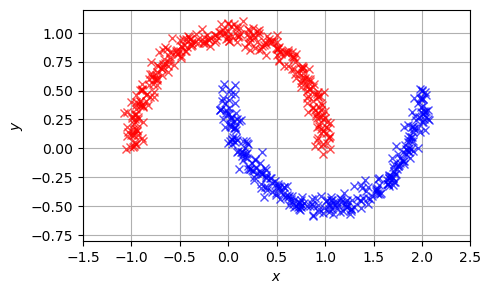

In [2]:
# create moon data, cluster and then label them
from sklearn.datasets import make_moons

# use different colours for reasons later
colors = "rb"  # red blue

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y==i, 0], X[Y==i, 1], f"{colors[i]}x", alpha=0.7)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

Going to first demonstrate LDA. We do train/test split, but we don't really need to standarise for this dataset. The predictions return labels, and the check on the score is simply how many labels did it get correct (`np.sum(Y_pred == Y_test)`).

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=4167)

In [4]:
# fit models
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

overall skill: 106 correct out of 120 (88.33%)
 


We have broad diagnostics of skill but it may be of interest to actually see what is the boundary the model decided to find. Here we can leverage `sklearn.inspection.DecisionBoundaryDisplay` for this purpose.

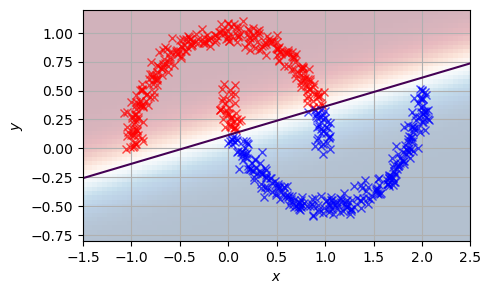

In [5]:
from sklearn.inspection import DecisionBoundaryDisplay

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

So everything above the line is predicted as red and below is blue, and there are some parts of the moon that gets predicted wrong. This is not entirely surprising because for this case there is no linear line in 2d that cuts the data cleanly in half.

Before we move on to QDA, note that you can use LDA as a way to do dimension reduction. For this problem the data is embedded in 2d, so the reduction goes to 1d. Within the lower dimension the idea is to find the best separator, which in this case is some horizontal line. Given the data mixing, there is no clean separation.

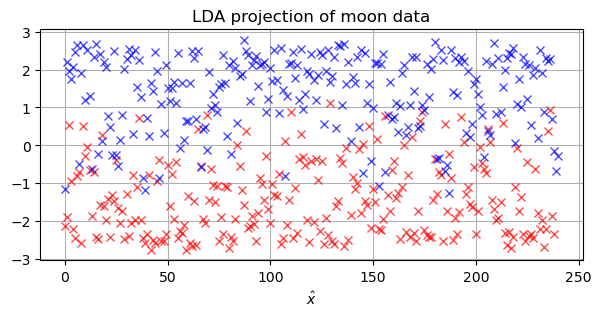

In [6]:
# reduction of dimenion by 1 in this case
X_transform = model.transform(X_train)

# plot out the transforms + projected data with labels
fig = plt.figure(figsize=(7, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X_transform[Y_train == i], f"{colors[i]}x", alpha=0.7)
ax.set_xlabel(r"$\hat{x}$")
ax.set_title(r"LDA projection of moon data")
ax.grid()

A similar thing can be done with QDA, although there is no dimension reduction procedure here with the `sklearn` implementation.

overall skill: 106 correct out of 120 (88.33%)
 


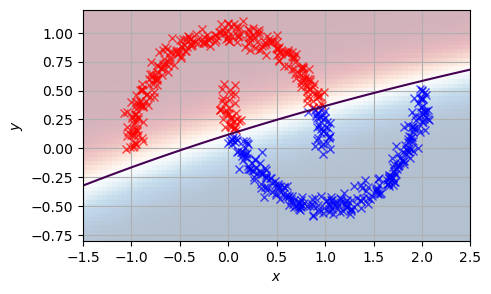

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# fit models
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

Here the boundary is a quadratic curve that gives a marginally better performance than LDA. This is perhaps not surprising because the separator has more complexity and is slightly more flexible.

> <span style="color:red">Q.</span> I didn't standardise the data, and I am fairly sure it doesn't actually do anything for this case. Convince yourself that statement is probably true numerically or otherwise.
>
> <span style="color:red">Q.</span> Here you probably don't need to check for robustness and cross-validation as such, because the data and the methods are simple enough, but give that a go to see how the prediction scores change.
>
> <span style="color:red">Q.</span> Try something similar for the swiss roll or S curve data embedded in 3d. The way I would do it is "unroll" the data somehow (use a dimension reduction technique to 2d), then artificially draw a line in the plane and call one half something and another half something else, then you do the classification. You could also try and have multiple labels (which we will see later with the penguins data).
>
> Note that the `DecisionBoundaryDisplay` routine will complain if the predictor requires more than two inputs (because plotting a surface of separation is hard). You could of course include dimension reduction techniques in the pipeline.

### Support Vector Machine (SVM)

If we take the moon data example above then you can argue there is no way I can separate the data unless I have enough complexity, which may then give me over-fitting. But that's only if I am stuck 2d; see below for an artificial example.

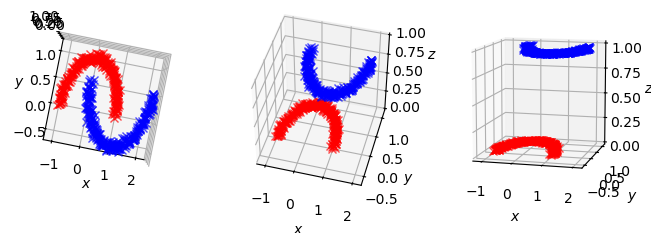

In [8]:
# use different colours for reasons later
colors = "rb"  # red blue

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

# artificially lift the data into 3d
fig = plt.figure(figsize=(8, 4))

# lift the data into 3d and shift the z-coordinate but some constant
X_3d = np.zeros((X.shape[0], X.shape[1]+1))  # make a bigger array
X_3d[:, :-1] = X                             # dump in the old data
X_3d[:, 2] = np.where(Y==0, 0.0, 1.0)        # add a z-coord related to label

elev_range = [90, 45, 10]
for j in range(3):
    ax = plt.subplot2grid((1, 3), (0, j), projection="3d")
    for i in range(2):
        ax.plot(X_3d[Y==i, 0], X_3d[Y==i, 1], X_3d[Y==i, 2], f"{colors[i]}x", alpha=0.7)
    ax.view_init(azim=-75, elev=elev_range[j])
    ax.set_box_aspect((1, 1, 1))
    ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$"); ax.set_zlabel(r"$z$");

If we do that then the separator is "obvious" to find. You can of course argue that I can arbitrarily promote the data to higher dimensions (effectively as a co-ordinate transformation), then I can always find a good separator (i.e. high-dimensional hyperplane) for it.

The idea of ***Support Vector Machine*** (SVM) is essentially to find a maximal separator between the labelled data, allowing for promotion to higher dimension space, but penalising that latter procedure. The result is again an optimisation problem.

> NOTE: The details are a bit complicated in that you actually solve a ***dual problem*** using the ***kernel trick***. Not going to elaborate on what that is.

In `sklearn` SVM is in the module `svm`, and we can try and do the above but with default SVM. We are going to use `SVC` which is the basic one for classification (C for classification; SVR is for regression). The default there uses the regularisation parameter `C=1` and `kernel=rbf` (Radial Basis Function). Have a look at [here](https://scikit-learn.org/stable/modules/svm.html) to see what those mean.

overall skill: 120 correct out of 120 (100.00%)


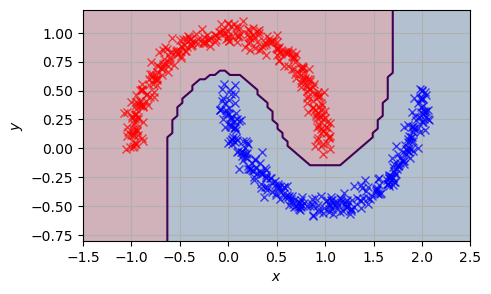

In [9]:
from sklearn import svm

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit models
# NOTE: Try kernel='linear', what is the result?
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)

print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",  # SVM has no probability associated with predictions
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

More or less what we expected! In this case we can get a perfect score because the data is in fact well-separated (but that's because the data noise level is fairly low).

In the below case I am going to do a whole load of different variants. I will be using this multiple times, so I am going to wrap it up in a subroutine that takes in the input and output data and does some plots.

> NOTE: Unlike the one above where I use different data for training and testing, the ones below use all the data for fitting, because it is only there to demonstrate differences in behaviour.

In [10]:
def plot_SVM_variants(X, Y, models, title, C=1.0):

    fig = plt.figure(figsize=(8, 6))

    for j in range(len(models)):

        model = models[j]

        # fit models
        model.fit(X, Y)

        # basic skill diagnostics
        Y_pred = model.predict(X)
        N = len(Y)
        skill_all = np.sum(Y_pred == Y)

        # do a prediction but on full data
        ax = plt.subplot(2, 2, j+1)
        for i in range(2):
            ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
        DecisionBoundaryDisplay.from_estimator(model, X,
            response_method="predict",  # SVM has no probability associated with predictions
            plot_method="pcolormesh",
            ax=ax,
            cmap="RdBu",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(model, X,
            response_method="predict",
            plot_method="contour",
            ax=ax,
            alpha=1.0,
            levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
        )
        if j % 2 == 0:
            ax.set_ylabel(r"$y$")
        if j > 1:
            ax.set_xlabel(r"$x$")
        else:
            ax.set_xticklabels([])
        if (j == 1 or j == 3):
            ax.set_yticklabels([])
        ax.set_title(f"{titles[j]}, full skill = {skill_all/N*100:.2f}%")
        ax.grid()

    return fig

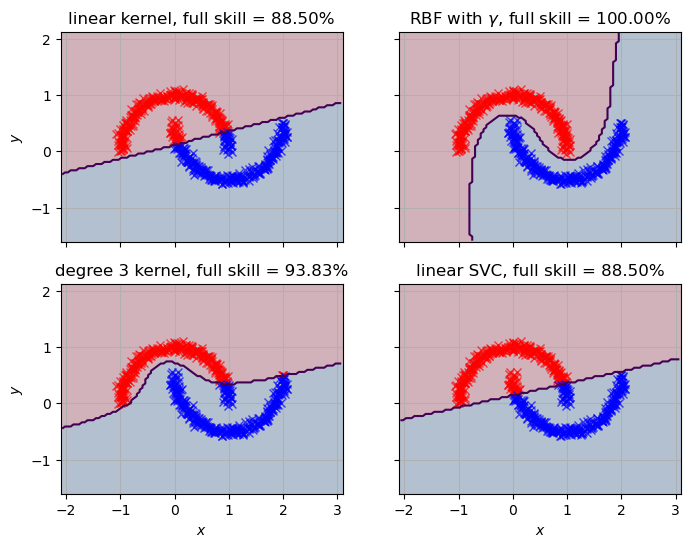

In [11]:
# refresh data

random_state = 0

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=random_state)

# cycle through an array of models
C = 1.0  # regularisation parameter (1.0 is the default, smaller is larger regularisation)
models = (
    svm.SVC(kernel='linear', C=C, random_state=random_state),
    svm.SVC(kernel='rbf', gamma=0.7, C=C, random_state=random_state),
    svm.SVC(kernel='poly', degree=3, C=C, random_state=random_state),
    svm.LinearSVC(C=C, random_state=random_state),
)
titles = ("linear kernel", r"RBF with $\gamma$", "degree 3 kernel", "linear SVC")

fig = plot_SVM_variants(X, Y, models, titles, C=C);

> <span style="color:red">Q.</span> Try the whole thing again but this time increase the noise in the data generation part (then we won't have a good separation).
>
> <span style="color:red">Q.</span> Try something similar for the swiss roll or S curve data embedded in 3d, with massaging of the data as before.
>
> <span style="color:red">Q.</span> Explore different model parameters to see what that does, and cross-validate things where relevant.

### Things to be aware of: data scaling

SVM is not scale-invariant and can be sensitive to scaling in the data. In the below case I artificially stretch the data in one co-ordinate by quite a large factor, and you can see the data starts behaving a bit strangely (particularly the `rbf` that previously had a 100% accuracy).

Standardisation is recommended in general. Try it for the penguins data later particularly if the `body_mass_g` feature is included, because that has completely different magnitudes compared to the others (and the fact that it doesn't even have comparable units...)

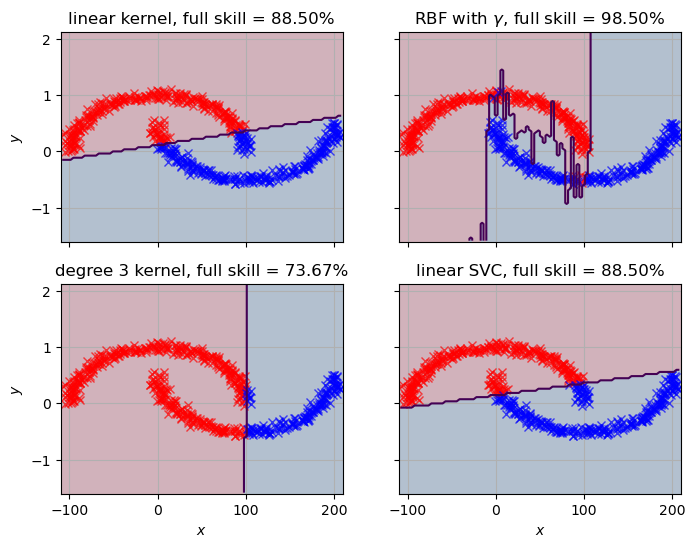

In [12]:
# artificially scaled data

random_state = 0
n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=random_state)

factor = 100
X[:, 0] *= factor  # stretch it in one direction by a factor

# try scaling here
# scalar = StandardScaler()
# X = scalar.fit_transform(X)

fig = plot_SVM_variants(X, Y, models, titles, C=C)

### Things to be aware of: unbalanced datasets

SVM has issues if the dataset is unbalanced, by which I mean there is noticeably more data in one class than the other. In the below code I am going to artificially remove some data from one class and then do SVM on those again.

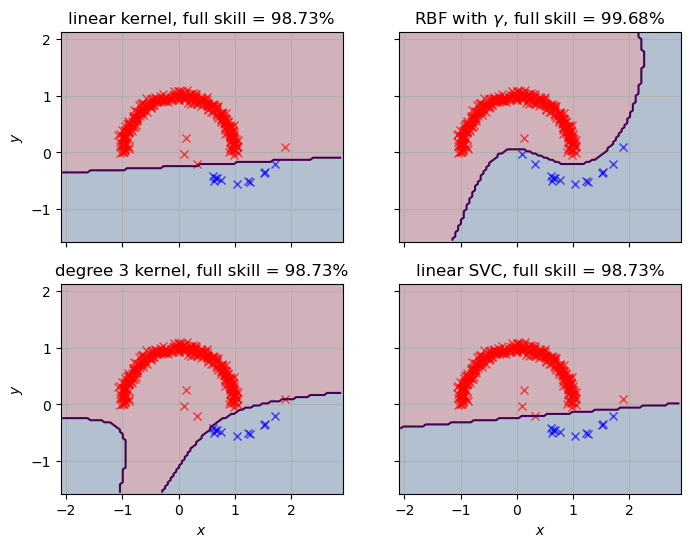

In [13]:
# artifically unbalanced data
random_state = 0
n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=random_state)

# define amount of data to keep, find index, choose an integer selection, and overwrite array
factor = 0.05
inds_full = np.where(Y==1)[0]
np.random.seed(random_state)  # force it to be deterministic
inds = np.random.choice(inds_full, int(factor * len(inds_full)), replace=False)
X = np.concatenate((X[Y==0, :], X[inds, :]), axis=0)
Y = np.concatenate((Y[Y==0], Y[inds]))

fig = plot_SVM_variants(X, Y, models, titles, C=C)

Several possible ways to deal with this are (can be used in combination, and not all of them will fix everything):

* Remove some data from the larger class (but this is removing data which can be a problem with smaller datasets)
* ***Bootstrap*** to bulk out the class that is low on samples (but requires interpolation and/or knowing something about the pdf of the data)
* Pass `class_weight="balanced"` when initialising the model
* Increase the regularisation `C` when initialising the model (in this case you want to DECREASE the value of `C`)

Below considers the latter two cases.

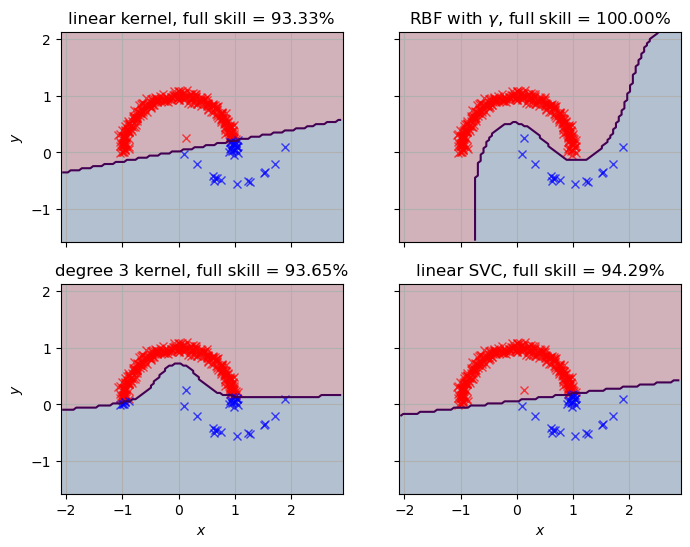

In [14]:
# modifying model parameters for unbalanced dataset
random_state = 0
C = 0.75  # regularisation parameter (1.0 is the default, smaller is larger regularisation)
models = (
    svm.SVC(kernel='linear', C=C, 
            random_state=random_state, class_weight="balanced"),
    svm.SVC(kernel='rbf', gamma=0.7, C=C, 
            random_state=random_state, class_weight="balanced"),
    svm.SVC(kernel='poly', degree=3, C=C, 
            random_state=random_state, class_weight="balanced"),
    svm.LinearSVC(C=C, 
                  random_state=random_state, class_weight="balanced"),
)

fig = plot_SVM_variants(X, Y, models, titles, C=C)

The rebalancing seems to improve the SVM using `rbf`, but only has marginal response in the other ones.

> <span style="color:red">Q.</span> Try the whole thing again but this time increase the noise in the data generation part (then we won't have a good separation).
>
> <span style="color:red">Q.</span> Try something similar for the swiss roll or S curve data embedded in 3d, with massaging of the data as before.
>
> <span style="color:red">Q.</span> Explore different model parameters to see what that does, and cross-validate things where relevant.

---
## b) Detour: Stochastic Gradient Descent (SGD) with different choices of loss and penalisations

So here I want to take a slight detour because some of the details will be relevant to neural networks later. We talked about ***gradient descent*** before as a means to solve the optimisation problem earlier: recally that for the landscape defined by the loss function $J$, around $J(\theta_n)$, you want to probe for the gradient information, and update to get $\theta_{n+1}$ depending on the direction where $J$ descends fastest. Formally to get the full gradient you would need to compute $J$ in some $n$-dimensional ball around $\theta$ to find the optimal direction.

The idea then is that you could consider some random directions instead of every direction, and use that to approximate the gradient. You potentially take a less direct route to the minimum along the $J$ landscape, but it is cheaper, and you could in principle use the information in the previous iterations to help you along the way. If the number of directions is 1, it's called ***stochastic gradient descent***; if it's more than 1 it's called ***mini-batch*** gradient descent (but also sometimes just labelled as "stochastic").

This kind of method is useful particularly for things like neural networks where there are a lot of entries in $\theta$ to adjust, so the dimensionality can be so large that full gradient descent is not computationally feasible. These type of methods also have some suggestion that it can sample the space better and not get stuck in a local minimum.

SGD itself is a method and not a classifier as such: when you choose the loss function (and appropriate penalisation) you define the type of classifier/regressor. For classifiers the kind of loss we want should be one-sided: you should incur a massive cost if you get the classification wrong. Below are some of the these, and I am going to plot these out first before describing them.

> NOTE: You can look through the code to see the mathematical form of these if you want; not going to type those out here. (I basically took the below graph from  [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html), although I renamed the variables.)

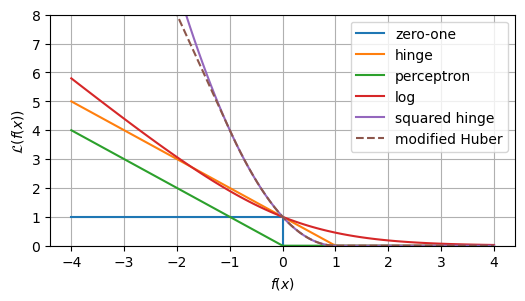

In [15]:
# whole bunch of loss functions

def modified_huber_loss(Y_true, Y_pred):
    z = Y_pred * Y_true
    loss = -4 * z
    loss[z >= -1] = (1 - z[z >= -1]) ** 2
    loss[z >= 1.0] = 0
    return loss

X = np.linspace(-4, 4, 101)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot([-4, 0, 0, 4], [1, 1, 0, 0], label="zero-one")
ax.plot(X, np.where(X < 1, 1 - X, 0), label="hinge")
ax.plot(X, -np.minimum(X, 0), label="perceptron")
ax.plot(X, np.log2(1 + np.exp(-X)), label="log")
ax.plot(X, np.where(X < 1, 1 - X, 0) ** 2, label="squared hinge")
ax.plot(X, modified_huber_loss(X, 1), "--", label="modified Huber")
ax.set_ylim((0, 8))
ax.legend()
ax.set_xlabel(r"$f(x)$")
ax.set_ylabel(r"$\mathcal{L}(f(x))$")
ax.grid();

We are making the decision here that anything positive is correct, and negative is bad (you can flip these accordingly of course). Respectively, we have:

* **Zero-one**: No cost if correct, other incur a cost of one. This is not really implemented, and is not considered further.
* **Hinge**: It's called "hinge" because it looks like a door hinge (the bit that connects the door to the wall). You start incurring a cost from 1, and this scales up linearly as you get more and more wrong.
* **Perceptron**: It's called "perceptron" because it is used in ***perceptrons***, which we will encounter later when we deal with neural networks. This is like hinge but it starts activating at 0 instead of 1.
* **Log**: Because it follows a (shifted) logarithm. Starts activating sooner but scales up faster than hinge and perceptron (because log blows up to infinity faster than linear functions).
* **Squared hinge**: Because you take the hinge loss function and square it.
* **Modified Huber**: Bit like the squared hinge but is more smooth, has some numerical advantages.

> NOTE: The main reason I wanted to digress into this here is that the loss functions defined here where flipped about the $y$-axis because possible candidates of ***activation functions***, which is important for neural networks later. For example, flipping the perceptron loss above would lead to ***ReLU***, which is usually the default activation for neural networks.

Note that the loss functions above are not convex and by itself may not have a minimum. A regularisation is usually needed; common choices are just the $L^1$, $L^2$ and elastic nets (a combination of both).

For a SGD classifer we would import this from `sklearn.linear_model.SGDClassifier`, and passing the keyword `loss=` in. The default regulariser is $L^2$ (`penalty="l2"`), which is fine for regression but not useful for classification. Below are some specific cases:

* `loss="hinge"` and `penalty="l2"` (the default if you just do `SDGClassifier()`: This reduces to linear SVM above.
* `loss="modified_huber"` is a bit like the above, but punishing outliers more. Comes with probability measures of the decision (cf. allows for `response_method="predict_proba"` in `DecisionBoundaryDisplay.from_estimator`)
* `loss="log_loss"` gives ***Logistic Regression***, which is really a classifier, although it has regression in the name. Sometimes called ***logit*** or ***Maximum Entropy*** classifier; not going to go into why that is.

Below I am just going to one for Logistic Regression.

overall skill: 106 correct out of 120 (88.33%)
 


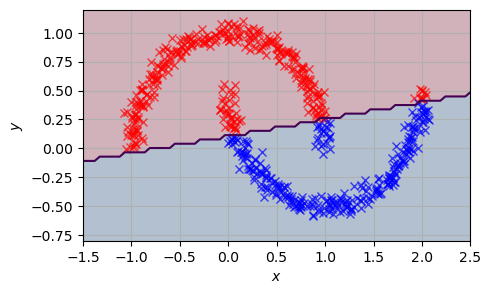

In [16]:
from sklearn.linear_model import SGDClassifier

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=4167)

# fit models
model = SGDClassifier(loss="log_loss")  # just logistic regression, with L2 penalisation
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

> <span style="color:red">Q.</span> You could also do logistic regression via `sklearn.linear_model.LogisticRegression`, and that has somewhat more options available. Convince yourself those two more or less do the same things.
>
> <span style="color:red">Q.</span> Try some other combinations (e.g. linear SVM with $L^1$ penalisation, which promotes sparsity). You have to be a bit careful that convergence of the solver may become an issue.
>
> <span style="color:red">Q.</span> One thing of interest to later is the ***learning rate*** that you can specify in the classifier; this is effectively the size of steps the solver takes to iterate towards a minimum. Try the options beyond the default.
>
> The learning rate is a possible model hyper-parameter that one might need to consider for cross-validation and helping for model convergence particularly when we deal with neural networks later.

## Demonstration: Penguins data

The example here considers doing classification on penguins data (which has three labels). We are going to do the case where there are two features (so I can show decision boundaries), and a case where I throw in all four features.

Recall that in `penguins` the `species` feature is text. We can convert that to numerical values via `sklearn.preprocessing.LabelEncoder`; going to load `StandardScaler` at the same time.

In [17]:
# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

# choose two particularly different features
feature_names = ["flipper_length_mm", "body_mass_g"]
X = df[feature_names].values

from sklearn.preprocessing import LabelEncoder, StandardScaler

# turn target from text to numerical values
encoder = LabelEncoder()
Y = encoder.fit_transform(df["species"])

print(f"{encoder.classes_} mapped to {encoder.transform(encoder.classes_)}")
print(" ")

loading data remotely
['Adelie' 'Chinstrap' 'Gentoo'] mapped to [0 1 2]
 


I am going to do this wrong first by using `SVM` by not scaling the data.

overall skill: 54 correct out of 69 (78.26%)


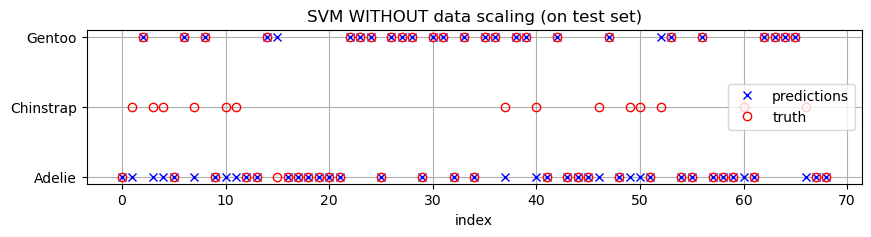

In [18]:
# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=4167)

# fit a model
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.set_xlabel("index")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(encoder.classes_)
ax.set_title(r"SVM WITHOUT data scaling (on test set)")
ax.legend()
ax.grid();

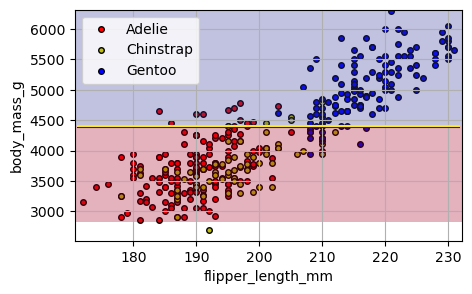

In [19]:
# do a prediction but on full data
Y_pred = model.predict(X)

colors = "ryb"  # red yellow blue

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for j in range(3): # 3 species
    idx = np.where(Y == j)
    ax.scatter(X[idx, 0], X[idx, 1], c=colors[j], edgecolor="k",
               s=16, label=encoder.classes_[j])
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="pcolormesh",
    ax=ax,
    cmap=plt.cm.RdYlBu,
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5, 1.5],  # because the labels are 0 1 2
)
ax.set_xlabel(f"{feature_names[0]}"); ax.set_ylabel(f"{feature_names[1]}");
ax.grid()
ax.legend();

So somehow it finds a boundary for `Chinstraps` to be absolutely tiny to the point it basically doesn't exist, so it makes no predictions for it. Lets see what happens if we standardise the data.

overall skill: 54 correct out of 69 (78.26%)
 


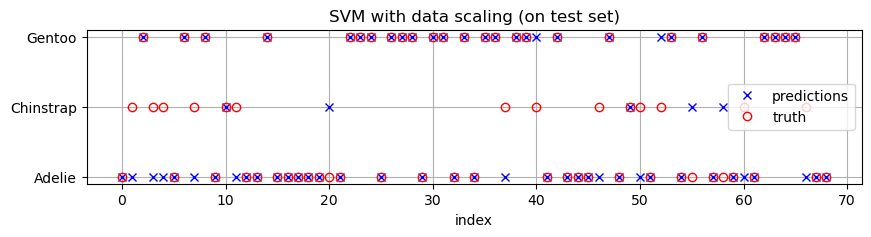

In [20]:
# standardise data X the proceed as usual

X = df[feature_names].values
# X = StandardScaler().fit_transform(X) # don't need to do Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=4167)
# JL: standardisation after train test split,
#     standardisation before split will have data leakage, i.e. test data is somehow seen / leak into training
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)     # dont fit test set, only transform using fitted scalar

# fit a model
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.set_xlabel("index")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(encoder.classes_)
ax.set_title(r"SVM with data scaling (on test set)")
ax.legend()
ax.grid();

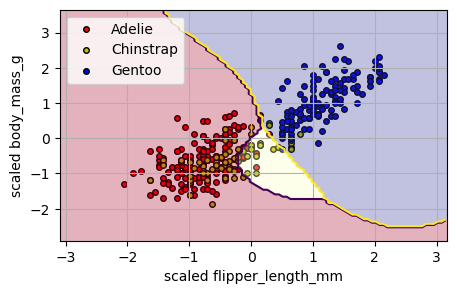

In [21]:
# do a prediction but on SCALED full data
X_scaled = StandardScaler().fit_transform(X)
Y_pred = model.predict(X_scaled)

colors = "ryb"  # red yellow blue

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for j in range(3): # 3 species
    idx = np.where(Y == j)
    ax.scatter(X_scaled[idx, 0], X_scaled[idx, 1], c=colors[j], edgecolor="k",
               s=16, label=encoder.classes_[j])
DecisionBoundaryDisplay.from_estimator(model, X_scaled,
    response_method="predict",
    plot_method="pcolormesh",
    ax=ax,
    cmap=plt.cm.RdYlBu,
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_scaled,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5, 1.5],  # because the labels are 0 1 2
)
ax.set_xlabel(f"scaled {feature_names[0]}"); ax.set_ylabel(f"scaled {feature_names[1]}");
ax.grid()
ax.legend();

So here it is at least the separators are carving out a region for predicting `Chinstraps`, although the accuracy is not that high.

What if we throw all the data in? We can evalute the scores although we can't really plot the boundaries anymore.

overall skill: 68 correct out of 69 (98.55%)
 


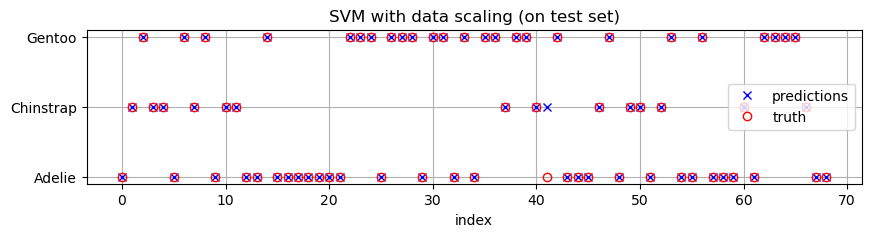

In [22]:
# as above but for all features
feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feature_names].values
# X = StandardScaler().fit_transform(X) # don't need to do Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=4167)
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# fit a model
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.set_xlabel("index")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(encoder.classes_)
ax.set_title(r"SVM with data scaling (on test set)")
ax.legend()
ax.grid();

> <span style="color:red">Q.</span> There is something to be said about decreasing the complexity by minimising the number of features. Consider keep the number of input features at two, but see which combination gives the best score.
>
> <span style="color:red">Q.</span> As above, but what if you do dimension reduction techniques on it first?
>
> <span style="color:red">Q.</span> Try other options under SVM, and/or types of classifers (with various options).
>
> <span style="color:red">Q.</span> Do robustness tests and cross-validation accordingly.

---
## c) Decision trees and ensemble methods

An example of a ***decision tree*** is as below:

<img src="https://i.imgur.com/UayMNei.png" width="450" alt='cat decision tree'>

From a manual point of view it's not too hard to see how we create decision trees, but how would a machine do this? The goal of this notebook is to spend a bit of time introducing some concepts behind how a single decision tree is created, and how you might use these as classifiers and/or regressors.

### Anatomy of a decision tree

Going to introduce some terminology so I can use it later:

* Root: This would be the start of the tree (the "is that for me?" box above).
* Leaves: The things at the end (the "I don't want it" and "That's for me" box above).
* Node: The intermediate blocks connecting the root to the leaves (in this case strictly speaking there isn't one; leaves can be pure nodes with no subsequent connectors).
* Branches: The connectors detailing the decisions (here it really should be the "yes" and "no").
* Levels/depth: Distance from the node and maximum number of levels (I would call above depth 1, arguably it could be 2).
* Parent/child: Usually refer to nodes that are directly connected. If a tree is going down like the above, the parent node would be the higher one (at a *lower* level; here the root node is the parent and the leaves are the child nodes).

### Recap in probability, and the concept of information entropy

(I want to spend a bit of time on this because similar ideas and terminology crop up when dealing with neural networks.)

Recall that a ***probability*** $p_i$ is a value between 0 to 1 assigned to an event $X_i$ occurring, with the condition that the sum of all probabilities should be 1, i.e. $\sum p_i = 1$. With the penguin data, this might be the probability of me randomly picking a sample out of the full dataset and the chances of me picking `Adelie`, `Chinstrap` or `Gentoo`. I am going to assume the process of drawing a sample is fair (i.e. follows a uniform distribution), then the probabilities are simply the number of samples of $X_i$ divided by the total sample size $N$. Let's actually do that in code form (because I want to use the result later).

In [23]:
# calculate the probability of drawing a particular species

# pandas can actually do this in one go
freq = df["species"].value_counts()
p = df["species"].value_counts(normalize=True)  # pandas can actually do this in one go

print(freq)
print(f"total number of samples = {np.sum(freq)}")
print(" ")
print(p)
print(f"total probability = {np.sum(p)}")
print(" ")

species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64
total number of samples = 342
 
species
Adelie       0.441520
Gentoo       0.359649
Chinstrap    0.198830
Name: proportion, dtype: float64
total probability = 1.0
 


Thing to notice for later is that the dataset is unbalanced, with fewer samples in `Chinstrap`.

If instead you want to find the probability in picking out a continuous variable like `body_mass_g`, then it doesn't make sense to talk about a probability of picking out a sample that has 4000 g, because it is almost surely not going to happen. Instead you talk about the probability of picking out a sample between (say) 3900 and 4100 g, i.e. you create ***bins*** or categories for the data to fall into first, then you proceed as before. This is of course just the same as creating a histogram, and in this case it is the area of the histogram (or pdf) that should sum (or integrate) to 1.

A quantity of interest is called the ***information entropy*** or the ***Shannon entropy***, defined as
\begin{equation*}
    H = \sum_{i=0}^N H_i = -\sum_{i=0}^N p_i \log_a p_i,
\end{equation*}
where I have not been very specific about the choice of base $a$. The original definition uses $a=2$, although $a=10$ and $a=e$ (so $\log \to \ln$) will also work.

> NOTE: It doesn't really matter because almost all the time it's the "shape" or functional behaviour of $H$ that is of importance, rather than its value. I am actually going to use the natural log (i.e. $a=e$), and I am simply going to denote that $\log$ (rather than use $\ln$). You can call the related logs in `numpy` via `np.log2`, `np.log10` and `np.log`.

This quantity shows up in ecology as the Shannon index and is supposed to be a measure of species diversity. The way you may want to think about entropy is the amount of surprise or information you get from doing a random sample from the dataset: $H=0$ is no surprise and perfect information, while high $H$ means the converse. To see this, consider the two extremes:

* If there is only one species, $p_0 = 1$ by construction, but $\log 1 = 0$ for any base, so $H = 0$. Drawing a sample here provides zero surprise and information, because you can't get any other possibility anyway.
* Convince yourself that $H$ is maximised for a uniform distribution, in which case $p_i = 1/(N+1)$, so $\log 1/(N+1) = \log 1 - \log (N+1) = -\log(N+1)$ for any base, so $H = (N+1)/(N+1)\times \log(N+1) = \log(N+1)$. Diversity is thus maximum, and drawing a sample is maximally surprising because there is no bias in the dataset.

The penguins data is not balanced and so the calculated Shannon entropy is not maximised.

In [24]:
# shannon index for all penguin data based on species

H = (-p * np.log(p)).sum()
print(f"H = {H:.6f} in base e")

# pick out number of unique entries
num_unique = len(df["species"].unique())
print(f"maximum possible Shannon entropy = {np.log(num_unique):.6f}")
print(" ")

H = 1.049915 in base e
maximum possible Shannon entropy = 1.098612
 


We can play the same game for continuous data; going to do this for the case `body_mass_g` feature as it serves to be an intermediate step to the next part in terms of some `pandas` syntax. The first part shows which bins it is actually going to dump the data in, and the second does the binning and computation of the probabilities, then entropy.

In [25]:
# cut the data and return bins
out = pd.cut(df["body_mass_g"], 5)
bins = out.unique()  # find the number of unique entries based on intervals
print(out.value_counts())
print(" ")

p = out.value_counts(normalize=True)
H = (-p * np.log(p)).sum()
print(f"H = {H:.6f} in base e")

# pick out number of unique entries
num_unique = len(bins)
print(f"maximum possible Shannon entropy = {np.log(num_unique):.6f}")
print(" ")

body_mass_g
(3420.0, 4140.0]    124
(4140.0, 4860.0]     83
(2696.4, 3420.0]     58
(4860.0, 5580.0]     55
(5580.0, 6300.0]     22
Name: count, dtype: int64
 
H = 1.482791 in base e
maximum possible Shannon entropy = 1.609438
 


### Information gain

The value of the entropy by itself is not that useful by itself. The question to ask here is that suppose I already chose a feature to segment the data (say `species`), then given a choice of choosing the next feature to segment data on, which one should I choose? One way to do this is to choose the feature that gives you the maximum ***information gain***: if high entropy is low information, I want to choose the feature that lowers the resulting entropy as much as possible. Information gain is calculated as
\begin{equation*}
    \mbox{IG} = H_p - \sum_{i=0}^N p_{c,i} H_{c,i},
\end{equation*}
where $H_p$ is the entropy of the parent class, and $p_c$ and $H_c$ are the probabilities and entropy associated with the child classes.

> NOTE: IG can be written in terms of the ***Kullback-Liebler*** (KL) divergence, which is an important concept in information geometry and used quite widely in ML. Not going to elaborate on what and how though; think of it as a distance between pdfs.
>
> IG is also close in form to ***cross entropy***, but also not going to elaborate how or why. ***Cross entropy*** is used for classification problems.

Probably easier to explain with an example:

1. If we take `species` as the parent feature, then we already calculated $H_p$ once above.
2. If I take `body_mass_g` as the child feature to further segment on, then I need to bin the data accordingly (also done above).
3. Find the number of `species` in those `body_mass_g` bins, and compute the occurrences and entropies accordingly. The below does this by creating the bins, finding the indices corresponding to the unique bins, pick out the data, and then computing the entropies.

In [26]:
# computing IG

# compute entropy of parent first
p = df["species"].value_counts(normalize=True)
H = (-p * np.log(p)).sum()

# compute intermediate variables
out = pd.cut(df["body_mass_g"], 5)
bins = out.unique()

H_i, n_i = np.zeros(len(bins)), np.zeros(len(bins))  # using n later to compute p_i
for i in range(len(bins)):
    ind = (out == bins[i])
    n_i[i] = df[ind]["species"].value_counts().sum()
    p_i = df[ind]["species"].value_counts(normalize=True)
    H_i[i] = (-p_i * np.log(p_i)).sum()

# compute information gain
IG = H - np.sum(H_i * n_i / np.sum(n_i))  # n_i / sum(n_i) = p_i
print(f"IG(parent = species, child = body_mass_g) = {IG:.6f}")
print(" ")

IG(parent = species, child = body_mass_g) = 0.460433
 


Positive IG here means the entropy is being reduced, which is expected. We should then check this for all features.

In [27]:
# compute IGs

# compute entropy of parent first
p = df["species"].value_counts(normalize=True)
H = (-p * np.log(p)).sum()

feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

for child_feature in feature_names:

    # compute intermediate variables
    out = pd.cut(df[child_feature], 5)
    bins = out.unique()

    H_i, n_i = np.zeros(len(bins)), np.zeros(len(bins))  # using n later to compute p_i
    for i in range(len(bins)):
        ind = (out == bins[i])
        n_i[i] = df[ind]["species"].value_counts().sum()
        p_i = df[ind]["species"].value_counts(normalize=True)
        H_i[i] = (-p_i * np.log(p_i)).sum()

    # compute information gain
    IG = H - np.sum(H_i * n_i / np.sum(n_i))
    print(f"IG(parent = species, child = {child_feature:<17}) = {IG:.6f}")

print(" ")

IG(parent = species, child = bill_length_mm   ) = 0.521951
IG(parent = species, child = bill_depth_mm    ) = 0.508796
IG(parent = species, child = flipper_length_mm) = 0.602198
IG(parent = species, child = body_mass_g      ) = 0.460433
 


Note that the IG is the largest for `flipper_length_mm`, i.e. it's reducing the entropy the most. It is then suggesting that, given we chose `species` as a parent, we probably want to segment on `flipper_length_mm` next. Thus this is one measure on how the entropy can guide the creation of branches and leaves in decision trees.

> NOTE: This is all relative and ordering matters: choosing `flipper_length_mm` as parent feature then `species` as child feature will not give the same IG.
>
> <span style="color:red">Q.</span> Modify code accordingly to include both continuous and discrete labels as parent/child features to come for the IG. I would do the continuous ones first before I do the discrete ones; you probably need to convert the labels to numerical values first, and then dump that into the `df` as part of a `pandas` dataframe so you can use the subroutines above.

To close, there is a similar quantity to the information entropy called the ***Gini index*** or ***Gini impurity***, which instead has the form
\begin{equation*}
    G = \sum_i p_i(1 - p_i).
\end{equation*}
The Gini index measures "impurities" in the dataset: the case with a single feature would have $p_i = 1$, so $G = 0$ and is completely "pure", and corresponds also to the $H=0$ case. $G=1$ would be the maximally mixed case. Both can be used to construct something like an information gain measure like the above, although the Gini index is more computationally efficient for binary decisions such as the trees we are considering. Information entropy and related ideas have more links with neural networks.

---
### Trees as classifiers

So for classifiers we are going to take target $Y$ to the `species` feature. Going to load a whole load of things and to demonstrate some features that one could dig into.

In [28]:
from sklearn.tree import DecisionTreeClassifier

feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feature_names].values
# X = StandardScaler().fit_transform(X)

encoder = LabelEncoder()
Y = encoder.fit_transform(df["species"])

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=4167)
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Going to fit a deliberately shallow tree (by specifying `max_depth=2`), and force it to use the information entropy criterion with `criterion="entropy"`. I am also going to query the feature importance in the fitted model with `model.feature_importances_`.

> NOTE: I am overriding the defaults are `max_depth=None` and `criterion="gini"`.

In [29]:
# fit a decision tree (deliberately shallow for showing)
model = DecisionTreeClassifier(max_depth=2, criterion="entropy")
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

overall skill: 66 correct out of 69 (95.65%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.2909
    bill_depth_mm        = 0.0904
    flipper_length_mm    = 0.6187
    body_mass_g          = 0.0000
 


The model does pretty well on the testing dataset. It also seems to be finding that `flipper_length_mm` is the most important feature, which is potentially consistent with our IG calculation above.

Note also that (on mine at least) the tree doesn't actually use the `body_mass_g` feature at all, because `body_mass_g` has zero feature importance. This is partly because I forced `max_depth=2` (so I can't have that much complexity anyway), and it basically managed to classify all the data with three features. This would be an early termination criterion: if all data is accounted for, stop any further creation of nodes.

> <span style="color:red">Q.</span> Why am I only using "potentially"? What is wrong with my assertion/statement here? (How is IG defined?)
>
> <span style="color:red">Q.</span> Convince yourself that for this case it doesn't matter really if I scale the data or not. In other words, decision trees are ***scale-invariant*** (but I am still scaling because it possibly lessens the computational burden a bit).

The thing with decision trees (and somewhat unlike most neural networks) you could actually look at the tree that gets formed so the model is arguably interpretable, although of course if your model is sufficiently complex that may be a mute point anyway. In the above I deliberately forced the tree to be simple so the display coming up is a bit easier to see. I can use `plot_tree` to actually plot a figure, or `export_text` to spit out the entries in the decision tree.

> NOTE: I passed in the `features_names=` argument so that it would display the feature names, otherwise it would display $X[2]$ etc., which refers to the third feature (in this case because Python counts from zero), which is `flipper_length_mm`.
>
> The colours in the trees denote the classes, as can be seen from the text description of the tree.

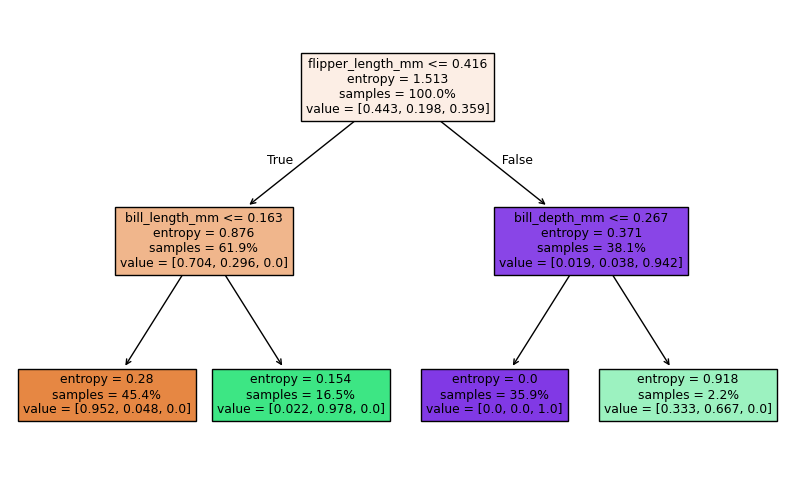

In [30]:
from sklearn.tree import plot_tree, export_text

fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
plot_tree(model, filled=True, proportion=True, feature_names=feature_names);

In [31]:
# export as text
print(export_text(model, feature_names=feature_names))
print(" ")

|--- flipper_length_mm <= 0.42
|   |--- bill_length_mm <= 0.16
|   |   |--- class: 0
|   |--- bill_length_mm >  0.16
|   |   |--- class: 1
|--- flipper_length_mm >  0.42
|   |--- bill_depth_mm <= 0.27
|   |   |--- class: 2
|   |--- bill_depth_mm >  0.27
|   |   |--- class: 1

 


If we do not force the maximum depth then we get the following.

overall skill: 64 correct out of 69 (92.75%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3042
    bill_depth_mm        = 0.1024
    flipper_length_mm    = 0.5481
    body_mass_g          = 0.0452
 
|--- flipper_length_mm <= 0.42
|   |--- bill_length_mm <= 0.16
|   |   |--- bill_length_mm <= -0.26
|   |   |   |--- bill_depth_mm <= -0.24
|   |   |   |   |--- bill_length_mm <= -0.79
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- bill_length_mm >  -0.79
|   |   |   |   |   |--- class: 1
|   |   |   |--- bill_depth_mm >  -0.24
|   |   |   |   |--- class: 0
|   |   |--- bill_length_mm >  -0.26
|   |   |   |--- body_mass_g <= -0.45
|   |   |   |   |--- class: 1
|   |   |   |--- body_mass_g >  -0.45
|   |   |   |   |--- class: 0
|   |--- bill_length_mm >  0.16
|   |   |--- body_mass_g <= 0.48
|   |   |   |--- class: 1
|   |   |--- body_mass_g >  0.48
|   |   |   |--- class: 0
|--- flipper_length_mm >  0.42
|   |--- bill_depth_mm <= 0.27
|   |   |--- class: 2
|   |

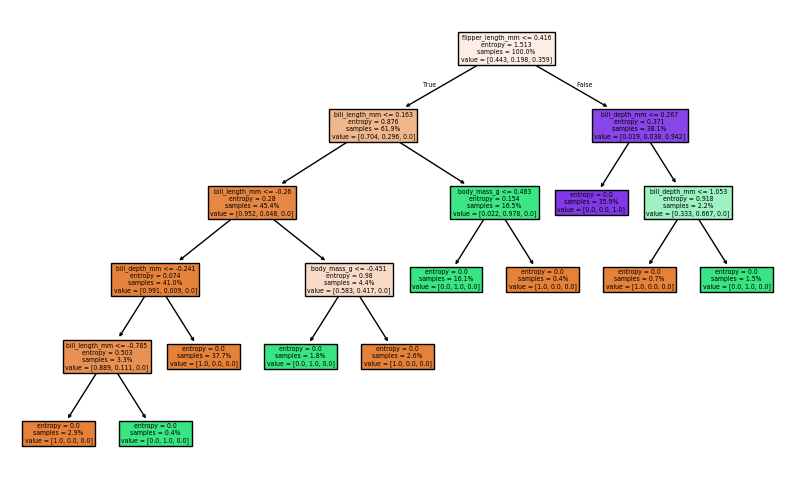

In [32]:
# fit a decision tree (deliberately shallow for showing)
model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

print(export_text(model, feature_names=feature_names))
print(" ")

fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
plot_tree(model, filled=True, proportion=True, feature_names=feature_names);

Note in this case class 2 (which is `Gentoo`) has a termination node that is quite high up on the tree close to the root node. If you remember this is consistent with our observations that `Gentoo` data seems to live in a different part of the feature space compared to the other two classes.

### Decision boundaries

We can plot out the decision boundaries easily if we only models using two features. Below takes three specific combinations just to demonstrate what these look like.

> NOTE: Note I've standardised the data so the units are not quite right.

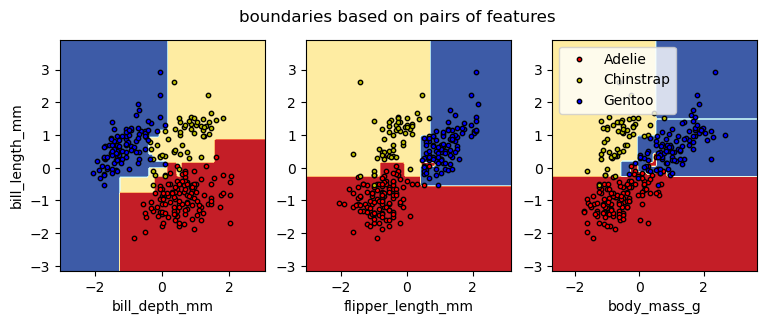

In [33]:
# visualise the decision boundary
from sklearn.inspection import DecisionBoundaryDisplay

combos = [[1, 0], [2, 0], [3, 0]]  # pre-define some pairs of features
colors = "ryb"  # red yellow blue

fig = plt.figure(figsize=(9, 3))

for i in range(3):
    # train a new model per cycle
    model = DecisionTreeClassifier().fit(X_train[:, combos[i]], Y_train)

    ax = plt.subplot(1, 3, i+1)
    DecisionBoundaryDisplay.from_estimator(
        model,
        X_train[:, combos[i]],
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax
        )
    # plot the actual data points in
    for j in range(3): # 3 species
        idx = np.where(Y_train == j)
        ax.scatter(X_train[idx, combos[i][0]], X_train[idx, combos[i][1]],
                   c=colors[j], edgecolor="k", s=10, label=f"{encoder.classes_[j]}")
    ax.set_xlabel(f"{feature_names[i+1]}")
    if i == 0:
        ax.set_ylabel(f"{feature_names[0]}")
ax.legend()

fig.suptitle(r"boundaries based on pairs of features");

### Dependence on `max_depth`

If we don't specify `max_depth` then the trees goes on until the leave nodes are "pure", i.e. either entropy or Gini index is zero. It is sometimes a good idea to limit `max_depth` as a control to possiblities of over-fitting. Below code changes that parameter to see how the skill varies as a function of `max_depth`.

In [34]:
# dependence of skill with varying max_depth

for max_depth in range(1, 6):
    # fit a decision tree with fixed seed
    model = DecisionTreeClassifier(criterion="entropy", 
                                   max_depth=max_depth, 
                                   random_state=167)
    model.fit(X_train, Y_train)

    # basic skill diagnostics
    Y_pred = model.predict(X_test)
    N = len(Y_test)
    skill_all = np.sum(Y_pred == Y_test)
    print(f"max_depth = {max_depth} overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
    print(f"fitted feature importance [1 = max]:")
    for i in range(len(feature_names)):
        print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

max_depth = 1 overall skill: 54 correct out of 69 (78.26%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.0000
    bill_depth_mm        = 0.0000
    flipper_length_mm    = 1.0000
    body_mass_g          = 0.0000
max_depth = 2 overall skill: 66 correct out of 69 (95.65%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.2909
    bill_depth_mm        = 0.0904
    flipper_length_mm    = 0.6187
    body_mass_g          = 0.0000
max_depth = 3 overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3082
    bill_depth_mm        = 0.0982
    flipper_length_mm    = 0.5760
    body_mass_g          = 0.0176
max_depth = 4 overall skill: 64 correct out of 69 (92.75%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.2965
    bill_depth_mm        = 0.1036
    flipper_length_mm    = 0.5542
    body_mass_g          = 0.0457
max_depth = 5 overall skill: 64 correct out of 69 (92.75%)
fitted featur

It looks like the model is reaching its peak performance around `max_depth=2` or `max_depth=3`.

### Dependence on `criterion`

Below does the same as above but using the (default) Gini criterion instead. Performance ends up being about similar.

In [35]:
# dependence of skill with varying max_depth

for max_depth in range(1, 6):
    # fit a decision tree with fixed seed
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=167)
    model.fit(X_train, Y_train)

    # basic skill diagnostics
    Y_pred = model.predict(X_test)
    N = len(Y_test)
    skill_all = np.sum(Y_pred == Y_test)
    print(f"max_depth = {max_depth} overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
    print(f"fitted feature importance [1 = max]:")
    for i in range(len(feature_names)):
        print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

max_depth = 1 overall skill: 54 correct out of 69 (78.26%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.0000
    bill_depth_mm        = 0.0000
    flipper_length_mm    = 1.0000
    body_mass_g          = 0.0000
max_depth = 2 overall skill: 66 correct out of 69 (95.65%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3622
    bill_depth_mm        = 0.0559
    flipper_length_mm    = 0.5819
    body_mass_g          = 0.0000
max_depth = 3 overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3660
    bill_depth_mm        = 0.0692
    flipper_length_mm    = 0.5530
    body_mass_g          = 0.0118
max_depth = 4 overall skill: 64 correct out of 69 (92.75%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3531
    bill_depth_mm        = 0.0679
    flipper_length_mm    = 0.5336
    body_mass_g          = 0.0454
max_depth = 5 overall skill: 64 correct out of 69 (92.75%)
fitted featur

> <span style="color:red">Q.</span> There are a whole load of other parameters one could specify for decision trees (e.g. see [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)). Have a play around with those.
>
> <span style="color:red">Q.</span> I can think you pass further options into `plot_tree` to beautify it accordingly, have a look at doing that.

## Ensemble methods

### TL;DR: ***Random forests*** and ***gradient boosting*** is just ***ensembles*** of decision trees.

<img src="https://i.imgur.com/vlEyC0x.jpeg" width="500" alt='forests of randoms'>

Loading data here again in case you want to run the below without the above.

In [36]:
# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


### Random forests

The idea here is that a single decision tree is prone to over-fitting, and the structure of the tree itself can demonstrate quite a bit of variability in the eventual classification/regression depending on initialisation and/or choice of data. One way to get around this is to train up a collection of trees (i.e. a "forest") and take an average of the decisions, and call that final product your classifer/regressor. Because of the aveaging operation you might suspect the resulting model to be more robust, display less variance and be less prone to over-fitting.

The way this roughly works is as follows the pictorial below (with exaggerations):

<img src="https://i.imgur.com/bOy1l4N.jpeg" width="1200" alt='schematic'>

### 1) Bootstrap sampling

In your training set you create sub-samples of the training data via ***bootstrap sampling***, a bit like when you did $K$-fold cross-validation. The difference here is you **allow for replacement** of data. As an example, if the whole dataset is $[a, b, c, d, e]$ and I allow sampling four of these to form one of my sub-training sets, then the following are permissiable under bootstrap sampling but not in $K$-fold splitting:

* $[a, b, a, c]$
* $[a, b, b, a]$
* $[a, a, a, a]$

Note that $[a, e, c, d]$ would be permissable under both with and without replacement sampling.

> <span style="color:red">Q.</span> In reality if you were doing $K$-folds you probably wouldn't get $[a, e, c, d]$ as one of the folds anyway, why is that?

### 2) Bagging (or boostrap aggregation)

***Bagging*** is just you training models based on the dataset obtained from bootstrap aggregation from the above. The ***random*** part in the "random forest" comes from the fact that the bootstrap sampling is going to introduce randomness in the created models.

Note the ensemble members are in general going to be weak learners, because the exposed sub-sample data size will likely be low. The idea is that you have multiple weak learners that aggregate into a robust stronger learner. See the [original paper](https://link.springer.com/article/10.1023/A:1018054314350) for why this should work.

### 3) Averaging / voting

Once you have the ensemble members, then when you use the ensemble to make a prediction, all of the members make a prediction, and the result is averaged for a regressor, or a majority vote is taken for a classifer.

Note because this is an ensemble method, some measures of probability in the predictions are in principle given.

> NOTE: The things described above can in principle be applied to other methods (e.g. linear models, neural networks), although it is most commonly used with decision trees.
>
> In `sklearn` the averaging and voting is simple in that the weights are uniform (no biases). You also only get votes (as a probability) in the classifier. Could in principle bully the code to deal with uneven weights, but this is not demonstrated here.

Below code demonstrates the usage of random forests with the penguin data, first using the `RandomForestClassifer` object. I am deliberately forcing the resulting trees to be shallow. with `max_depth=2`, and I create 20 trees here (`n_estimators=20`).

In [37]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.inspection import DecisionBoundaryDisplay

# aim: predict species from features (exactly as in trees basically)
feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feature_names].values

# turn target from text to numerical values
encoder = LabelEncoder()
Y = encoder.fit_transform(df["species"])

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# use an ensemble of 20 trees (but same max_depth and criterion as before)
model = RandomForestClassifier(max_depth=2, n_estimators=20, criterion="entropy",
                              random_state=4167)
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")

overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3102
    bill_depth_mm        = 0.2054
    flipper_length_mm    = 0.4550
    body_mass_g          = 0.0294


Note in contrast to the decision tree example in the previous section, when I specify `max_depth=2` I end up not using the `body_mass_g` feature. Here the feature importance shows up as a non-zero (but small) value, indicating that some of the ensemble members did pick that feature up to do segmentation on.

We can visualise some of the ensemble members below.

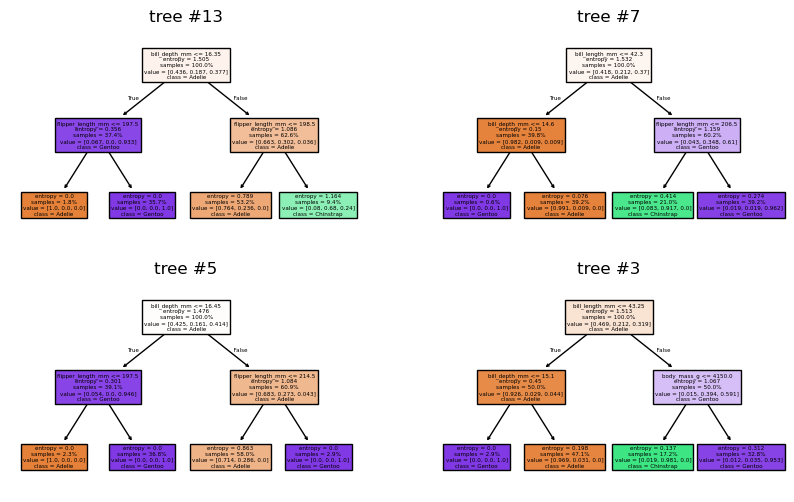

In [38]:
# visualise some of trees

# randomly choose 4 of the "n_estimators" to plot
inds = np.arange(20)
np.random.shuffle(inds)
ind = inds[:4]  # pick out the first four

fig = plt.figure(figsize=(10, 6))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plot_tree(model.estimators_[ind[i]], filled=True, proportion=True, ax=ax,
             feature_names=feature_names, class_names=encoder.classes_)
    ax.set_title(f"tree #{ind[i]}")

The `RandomForestClassifier` object comes with probability measures that we can probe, using `model.predict_proba()`. `X_test` should be the input in this case, and the outputs are the probabilities over the ensemble (of size `n_estimators`) of predicting class `0`, `1` or `2` (corresponding to `Adelie`, `Chinstrap` and `Gentoo`).

In the below I plot the probabilities, and the classifier returns the predicted label associated with the largest probability. I also label the actual labels by the bars with the brightest bar. Notice then the tallest bars do not correspond to the brightest, i.e. a wrong classification, although it is mostly the case. This observation is consistent with the summary statistics above.

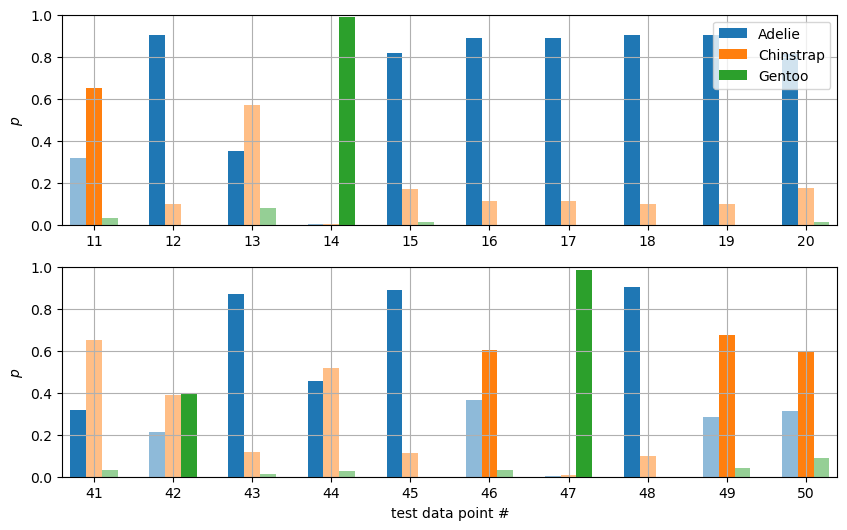

In [39]:
probs = model.predict_proba(X_test)
x = np.arange(len(Y_test))
width = 0.2

fig = plt.figure(figsize=(10, 6))

ax = plt.subplot(2, 1, 1)

# do a quick plot for legend purposes but never actually show it
x_temp = -10
for j in range(3):
    ax.bar(x_temp+(j-1)*width, probs[0, j], width=width, color=f"C{j}",
           label=f"{encoder.classes_[j]}")

for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([10.6, 20.4])
ax.set_ylim([0, 1])
ax.set_ylabel(r"$p$")
ax.grid()
ax.legend()

ax = plt.subplot(2, 1, 2)
for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([40.6, 50.4])
ax.set_ylim([0, 1])
ax.set_xlabel("test data point #")
ax.set_ylabel(r"$p$")
ax.grid();

### Out-Of-Bag score

This is a measure of how we might expect the models to generalise to new data. First, ***out-of-bag*** is the complement of the bagged samples: following example above, if your whole dataset is $[a,b,c,d,e]$, and the bagging gives a subset of $[a, c, b, a]$, then the out-of-bag part is
\begin{equation*}
    \mbox{OOB} = [a,b,c,d,e] \setminus [a,c,b,a] = [a,b,c,d,e] - [a,b,c] = [d, e],
\end{equation*}
where $\setminus$ is to mean be a set operation and ignoring duplicates.

The out-of-bag score is then the average skill of the ensemble members in predicting things out-of-bag. To enable this metric we pass `oob_score=True` in (it is `False` by default because then you do fewer calculations). A value of 1 means the members all predicted with 100% accuracy, and a value closer to 1 would suggest models are likely going to generalise better to unseen data.

In [40]:
# use an ensemble of 20 trees (but same max_depth and criterion as before)
model = RandomForestClassifier(max_depth=2, n_estimators=20, criterion="entropy",
                              random_state=4167, oob_score=True)
model.fit(X_train, Y_train)
print(f"model OOB accuracy = {model.oob_score_*100:.4f}%")
print(" ")

model OOB accuracy = 93.0403%
 


> <span style="color:red">Q.</span> For me the problematic test set data seems to be at index 13, 41 and 42. Have a look and those associated data points and see if there is a reason they are particularly hard for the prediction step (e.g. are they in a region where the data is particularly "mixed"?)
>
> <span style="color:red">Q.</span> Try some of the above for `RandomForestRegressor`, e.g. do the prediction problem I did last time. The thing you don't have access to are the probabilities of the predictions (the returned value is an average of all ensemble members).
>
> <span style="color:red">Q.</span> Consider changing other things such as pruning parameter `ccp_alpha`, `max_depth`, `min_samples_leaf`, `criterion` and see how performance differs. Could also do cross-validation and hyper-parameter tuning accordingly.

### Gradient boosting

The idea of ensemble methods is that you train a whole load of weak models, but the variance of the models are reduced through some sort of averaging procedure, leading to ensemble predictions that are more robust, but it may or may not say anything about the bias. The idea of ***boosting*** is to target the bias by targeting the problematic predictions, and considers the following pipeline:

1. Train an ensemble of models again, and identify the particularly weak models, i.e. the ones that got misclassified or had particularly large prediction errors.
2. Take those biases and compute residuals/mismatches/losses, change the weighting of the **data** to improve those particularly weak models, with the aim to "boost" the performance of the overall ensemble.
5. Re-train the model, repeat the processing of weight updates, and iterate until you get some convergence of the overall ensemble.

In that sense it's an optimisation problem (again!), hence my usage of familiar terms. The ***gradient*** part is that it uses (stochastic) gradient descent type methods to solve the optimisation problem associated with ***boosting***.

The demonstration below applies `GradientBoostingClassifier` to the same problem as above.

In [41]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# use an ensemble of 20 trees (but same max_depth and criterion as before)
model = GradientBoostingClassifier(max_depth=2, n_estimators=20,
                                   random_state=4167)
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.4111
    bill_depth_mm        = 0.0780
    flipper_length_mm    = 0.4415
    body_mass_g          = 0.0693
 


So in this case with basically the same settings as the `RandomForestClassifer` the skill on the test set is comparable to the random forests. What is slightly different are the associated probabilities in the resulting trees.

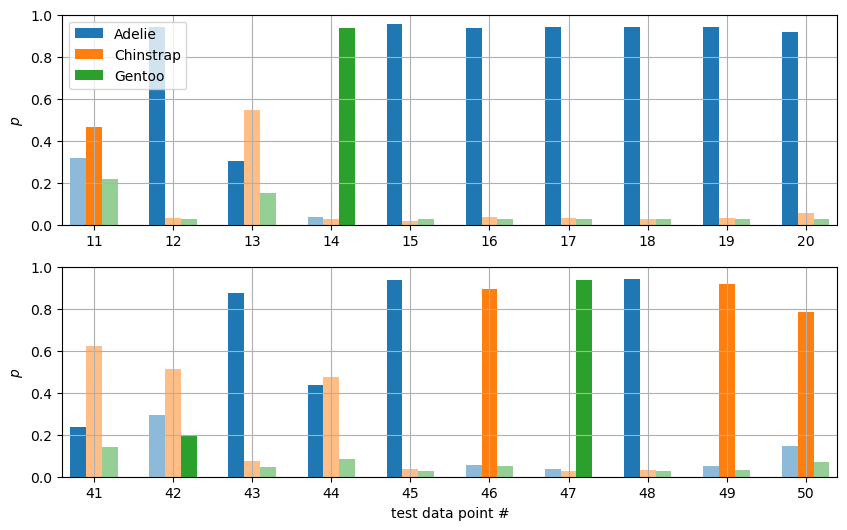

In [42]:
# plot the associated probabilities
probs = model.predict_proba(X_test)
x = np.arange(len(Y_test))
width = 0.2

fig = plt.figure(figsize=(10, 6))

ax = plt.subplot(2, 1, 1)

# do a quick plot for legend purposes but never actually show it
x_temp = -10
for j in range(3):
    ax.bar(x_temp+(j-1)*width, probs[0, j], width=width, color=f"C{j}",
           label=f"{encoder.classes_[j]}")

for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([10.6, 20.4])
ax.set_ylim([0, 1])
ax.set_ylabel(r"$p$")
ax.grid()
ax.legend()

ax = plt.subplot(2, 1, 2)
for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([40.6, 50.4])
ax.set_ylim([0, 1])
ax.set_xlabel("test data point #")
ax.set_ylabel(r"$p$")
ax.grid();

The thing that is probably true in this case is that where the bars were already tall in the random forest case it is even taller here.

Interestingly, both classifers are failing at the same prediction points (for me it's index 13, 41 and 42). It is perhaps of interest to have a look at what is going on there.

> <span style="color:red">Q.</span> For me the problematic test set data seems to be at index 13, 41 and 42. Have a look and those associated data points and see if there is a reason they are particularly hard for the prediction step (e.g. are they in a region where the data is particularly "mixed"?)
>
> <span style="color:red">Q.</span> Try some of the above for `GradientBoostingRegressor`, e.g. do the prediction problem I did last time. The only thing you don't have access to are the probabilities of the predictions (the returned value is an average of all ensemble members).
>
> <span style="color:red">Q.</span> Consider changing other things such as pruning parameter `ccp_alpha`, `max_depth`, `min_samples_leaf`, `criterion` and see how performance differs. Could also do cross-validation and hyper-parameter tuning accordingly.

----------------
# More involved exercises with this notebook

## 1) Other classifiers

There are other classifiers I didn't go through because they either follow the same principles we have encountered before, or they are completely different (e.g. dealing quite a bit with probability). These include:

* Ridge classification ($L^2$ penalisation as in linear models; can also do regression).
* Logistic classification (it's called `LogisticRegression` in `sklearn` though; it is part of `linear_model`, and is a special case of Generalised Linear Models).
* Nearest Neighbours (somewhat related to clustering things we have seen; can also do regression).
* Gaussian Processes (probabilistic classifiers; can also do regression).
* Naive Bayes and its extensions (as above).

Have a look at some of these.

(I personally think the Gaussian Processes and Bayesian approaches are the most interesting, because they can provide soft boundaries and measures of uncertainty. I guess just using them is fine, but understanding what they do with take a bit more work.)

## 2) Classifying cats and dogs

#### (This one may be part of an upcoming assignment.)

Try and do cats and dogs classification. You may or may not want to use dimension reduction approaches first.

You may also want to revisit again after all the subsequent lectures (decision trees, random forests, neural networks). This is a hard test in general and skill is not expected to be high.

## 3) More with SVM

You can use `svm.SVR` for doing regression, try that with some previous examples encountered.

There are also other variants of SVM (`NuSVC` and `NuSVR`), have a look and see what those are, apply them to some examples considered here and see how the results compare accordingly.

## 4) Regression

You can do regression with the SGD and random forests / gradient boosting stuff too. Have a look on the manual on what kind of loss functions you can use etc. and apply them to some examples considered here or previously also (e.g. penguins data, time series forecasting with `elnino34_sst.data`, Lotka-Volterra, Lorenz, or similar).

## 5) Image classification and/or extrapolation

This is a hard problem. Going to the raw images of cats and/or dogs, consider training

1. Classifiers for cats and dogs,
2. Regressors on half the face and using it to predict the other half. Analyse the skill on training data, testing data, the need for standardising the data, analysis of the model coefficients, dependence on the propotion of face exposed to model, cross-validation and etc.

From a coding point of view it is potentially easier to use the left half of the face to predict the right half (idea below). You can try top and bottom also.

Just be aware if you use the full image it might be slow (I never managed to get `GradientBoostingRegressor` to converge for the regression problem, although you could try `HistGradientBoostingRegressor` instead). You may or may not want to do dimension reduction on these first, which will probably help speed up the classification problem quite a bit; not sure about the regression problem.

## 6) Extreme Gradient Boosting with XGBoost

One significant advancement in machine learning is the advent of ***extreme gradient boosting***. Look up what extreme gradient boosting means and what it is doing. The Python package `xgboost` has gained a lot of popularity. See if you can use `xgboost` for the `penguins` data; see documentation [here](https://xgboost.readthedocs.io/en/stable/get_started.html).

Google Colab has `xgboost` installed by default. **Be very careful with hyperparameters (`n_estimators`, `max_depth` etc.)! Control your model wisely and do not go insane with parameters!**

Notice any advantages / disadventages of `xgboost`?

In [43]:
# import xgboost
# from xgboost import XGBClassifier
# ...